# Neural Style Transfer

Nueral Style Transfer using PyTorch. Original paper by *Leon A. Gatys*, *Alexander S. Ecker* and *Matthias Bethge* [here](https://arxiv.org/abs/1508.06576). Majority of the code used for this repository is authored by *Alexis Jacq* and edited by *Winston Herring*. The link for their article can be found [here](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html).

### Import packages

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F

# efficient gradient descents
import torch.optim as optim 

from PIL import Image
import matplotlib.pyplot as plt

# transform PIL images into tensors
import torchvision.transforms as transforms 

import torchvision.models as models

#to deep copy the models
import copy

If we have a GPU available, use it! If not, we use the CPU which will take a little longer to run the network.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### What are we trying to accomplish?

To keep it simple, **Neural Transfer** involves reproducing the contents of an *input image* with the artistic style of a *style image*. For example, can we take the *style* of the watercolor painting below and the *content* of the turtle image in order to produce a third image which is a 'combination' of the two. As you can see, this can lead to very fun results!

**Source:** Pytorch Advanced Tutorials
![Example](https://pytorch.org/tutorials/_images/neuralstyle.png)

### Basic Theory 

Two distances, one for the content (D<sub>C</sub>) and one for the style (D<sub>S</sub>) are defined. They measure how different two images are content-wise and stylistically. 

A third image, called the input image, which can be white noise or the content image itself is then transformed so that its content-distance with the content-image and its style-distance with the style-image are both minimized.

### Load the content and style images

The original PIL images have values between 0 and 255. These need to be converted to torch tensors, with values between 0 and 1. This is becasue neural networks from the torch library are trained on the same range. Passing inputs in the 0 to 255 range will render the activated feature maps of the network useless. Another important detail is that the *content* and *style* images need to have the same dimensions. We'll resize them to a fixed value to ensure this.

In [3]:
# Use smaller image size if gpu isn't available
if torch.cuda.is_available():
    imsize = (512, 512) 
else:
    imsize = (256, 256)  

# Resize image and transform to torch tensor
tfms = [
    transforms.Resize(imsize),
    transforms.ToTensor()
]
loader = transforms.Compose(tfms)

def image_loader(img_path):
    img = Image.open(img_path)
    # Insert 1 in shape of the tensor at axis 0
    # Extra dimension is required to fit the network's input dimensions
    img = loader(img).unsqueeze(0)
    return img.to(device, torch.float)


style_img = image_loader("./data/picasso.jpg")
content_img = image_loader("./data/sarthak.jpg")

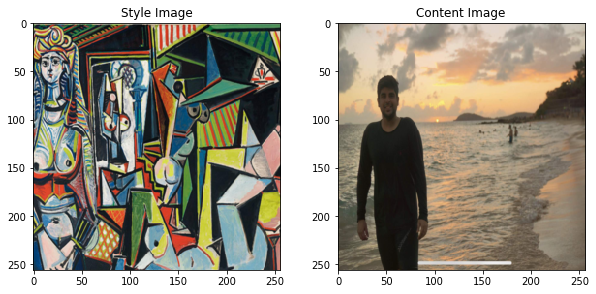

In [4]:
# Convert tensor to PIL Image
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    # Clone the tensor so it's not changed in-place
    image = tensor.cpu().clone()
    # Removed the extra dimension added previously
    image = image.squeeze(0)      
    image = unloader(image)
    # Now we have a normal image, let's display it
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure(figsize=(10,10))

plt.subplot(221)
imshow(style_img, title='Style Image')

plt.subplot(222)
imshow(content_img, title='Content Image')

### Loss Functions

The two kinds of loss we will minimize during neural style transfer are the **Content Loss** and **Style Loss**. Let's understand and implement both these losses.

### Content Loss

This loss function calculates the weighted *content distance* for an individual layer between the input image and the content image. To achieve this, the loss function uses the feature maps of a particular layer for both these images. It is implemented as a torch [module](https://pytorch.org/docs/stable/nn.html) with a constructor that takes the feature map of the content image at a layer as an input. The mean squared distance between the two sets of feature maps is then computed using *nn.MSELoss*.

This module is added directly after the convolution layer(s) that are being used to compute the content distance. In order to make this layer transparent, we define a forward method that computes the *content loss* and then returns the layer’s input. The computed loss is saved as a parameter of the module.

In [5]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        # Sub-class this class
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss

To setup this loss function, we'll compute a gram matrix, which is the result of multiplying a given matrix by its transpose. The given matrix in this case is composed of the different feature maps of a particular layer in the network. The inner products allow us to compute 'correlations' between the different features and these contain the stylistic properties of the image. The gram matrix is then normalized.

**Note on normalization of the gram matrix**: It is to counteract the fact that the first layers have more dimensions and will thus yield larger values in the Gram matrix. This will cause them to have a larger impact during the gradient descent and this is not ideal since *Style features* tend to be in the deeper layers of the network.

In [6]:
def gram_matrix(input):
    # a is batch size, equal to 1
    # b is the number of feature maps
    # (c,d) are dimensions of feature map
    a, b, c, d = input.size()  

    # resize matrix to [b,(c*d)] form
    features = input.view(a * b, c * d)  
    
    # Compute the Gram-Matrix and normalize it
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

Similar to the *content loss* function, the style distance is computed using the MSE between Gram Matrix of the *Input Image* and Gram-Matrix of the *Style Image*.

In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        # Sub-class this class
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input